## **Background**

As we discussed in class, LSTM model failed to predict the future price of a given stock due to the in-direct correlation between the future price and previous prices. However, the "predicted" stock value may be applicable for triggering a buy-sell signal whenever the predicted line cut through the actual price line. Therefore, in this assignment, I tried to investigate the performance of these signals by making use of the LSTM model and CNN-LSTM model to perform a simple trading strategy.

## **Data prepare and model fitting**

In [ ]:
### Import the libray and download the data
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
### Fetch MSFT stock data
ticker = 'TSM'
start_date = '2020-01-01'
end_date = '2025-08-01'
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
data = data['Adj Close']
data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,TSM
Date,
2020-01-02,54.094990
2020-01-03,52.311047
2020-01-06,51.707382
2020-01-07,52.545296
2020-01-08,52.932716


In [ ]:
### check any Nan Data
data.isnull().values.any()

np.False_

<Axes: xlabel='Date'>

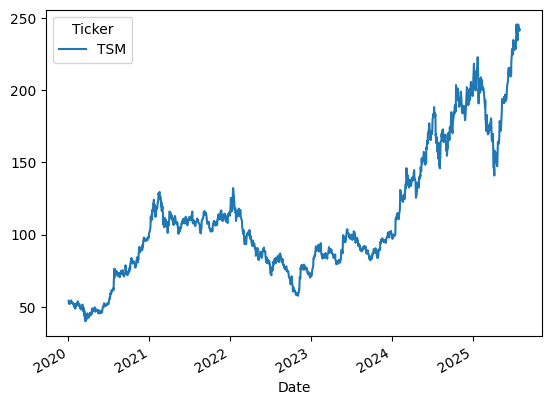

In [ ]:
data.plot()

In [ ]:
### Apply sklearn(Scikit-learn) machine learning for the prediction and MinMaxScaler module for normalizing the value
from sklearn.preprocessing import MinMaxScaler

In [ ]:
### Preprocess data with scale in between 0-1 for MinMaxScaler with stock price for pattern analysis more effectively for all prediction as below
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

In [ ]:
### Apply 80% of historical MSFT price data for training purpose; with every 30 days historical data to predict the next day's price
train_percentage = 0.9
time_step = 20

In [ ]:
### Prepare training and testing data
train_size = int(len(data_scaled) * train_percentage)

In [ ]:
### Create a function prepare the data for ML model to predict stock price by using 30 days MSFT's stock price to predict the 31st day's price
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
### Splits MSFT historical stock data into training set 80% and testing sets 20% to teach the model how to predict future prices
X_data, y_data = create_dataset(data_scaled, time_step)
X_train, y_train = X_data[:train_size], y_data[:train_size]
X_test, y_test = X_data[train_size:], y_data[train_size:]

In [ ]:
### 80% = 2012 data days for training each 30 days cycle
X_train.shape, y_train.shape

((1261, 20), (1261,))

In [ ]:
# Reshape data for LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Reshape

In [ ]:
# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    # 50 units of LSTM cell
    # return_sequences=True, mean the intermedate time value will also be return (batch_size, time_step, N)
    Dropout(0.2), # fix 20% of parameter of the 1st LSTM layer to prevent overtraining
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1) # Final layer to fit the output of 2nd LSTM layer to our target (30th day price)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_cnnlstm = Sequential([
    # CNN layers to extract features,
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(time_step, 1)),
    # filter = 64, means 64 diff kernels will be used, the form of kernel would determined by the network during learning
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Dropout(0.2),

    # LSTM layers to capture temporal patterns
    LSTM(units=50, return_sequences=True),
    LSTM(units=50),
    Dropout(0.2),

    # Output layer - predicts the next day's price
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
#Increasing units in each LSTM layer allows the model to capture more detailed pattern
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cnnlstm.compile(optimizer='adam', loss='mean_squared_error')
model_cnnlstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,859 (218.20 KB)

 Trainable params: 55,859 (218.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0446
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 16/20
40/40 ━

In [ ]:
model_cnnlstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0356
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 16/20
40/40 

In [ ]:
# Make predictions
train_predict_lstm = model_lstm.predict(X_train_reshaped)
test_predict_lstm = model_lstm.predict(X_test_reshaped)
train_predict_cnnlstm = model_cnnlstm.predict(X_train_reshaped)
test_predict_cnnlstm = model_cnnlstm.predict(X_test_reshaped)

# Inverse transform predictions
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
train_predict_cnnlstm = scaler.inverse_transform(train_predict_cnnlstm)
test_predict_cnnlstm = scaler.inverse_transform(test_predict_cnnlstm)

### Inverse transform actual values - Converts the scaled actual prices (from y_train and y_test) back into real dollar values for comparison
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


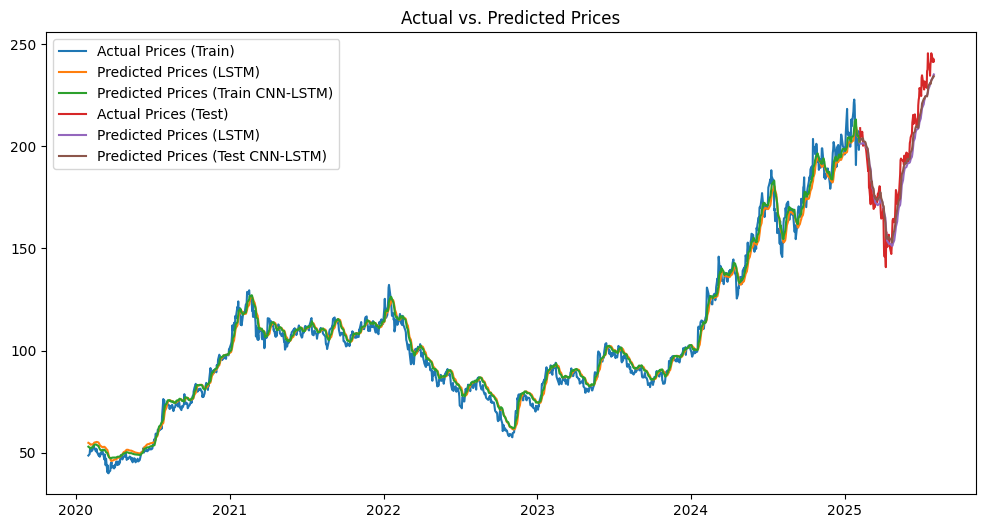

In [ ]:
# Adjust index ranges for plotting to match dimensions
plt.figure(figsize=(12, 6))

# Plot actual vs. predicted for training
plt.plot(data.index[time_step:time_step + train_size], y_train_inv.flatten()[:len(train_predict_lstm)], label='Actual Prices (Train)')
plt.plot(data.index[time_step:time_step + train_size], train_predict_lstm.flatten(), label='Predicted Prices (LSTM)')
plt.plot(data.index[time_step:time_step + train_size], train_predict_cnnlstm.flatten(), label='Predicted Prices (Train CNN-LSTM)')

# Plot actual vs. predicted for testing
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict_lstm)], y_test_inv.flatten()[:len(test_predict_lstm)], label='Actual Prices (Test)')
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict_lstm)], test_predict_lstm.flatten(), label='Predicted Prices (LSTM)')
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict_cnnlstm)], test_predict_cnnlstm.flatten(), label='Predicted Prices (Test CNN-LSTM)')

plt.legend()
plt.title('Actual vs. Predicted Prices')
plt.show()

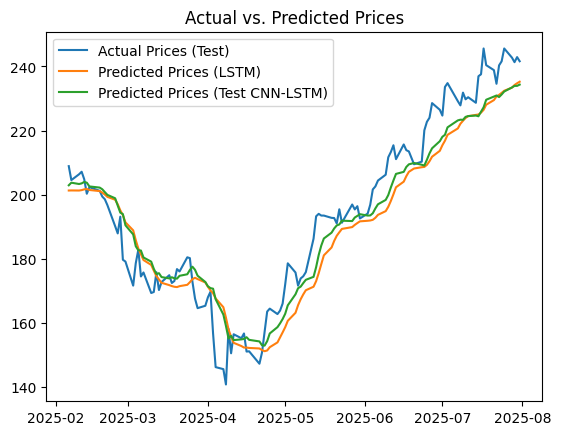

In [ ]:
# Plot actual vs. predicted for testing
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict_lstm)], y_test_inv.flatten()[:len(test_predict_lstm)], label='Actual Prices (Test)')
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict_lstm)], test_predict_lstm.flatten(), label='Predicted Prices (LSTM)')
plt.plot(data.index[train_size + time_step:train_size + time_step + len(test_predict_cnnlstm)], test_predict_cnnlstm.flatten(), label='Predicted Prices (Test CNN-LSTM)')

plt.legend()
plt.title('Actual vs. Predicted Prices')
plt.show()

## **Profitability comparsion**

To compare the performance, we perform the folloing trading strategy:



1.   Consider the buish market only (EMA10 > EMA50)
2.   Consider the period from 2024-01-01 (almost bullish market)
3.   at time t=0, we held 0 stocks
4.   when time t > 0, if actual price > predicted price and EMA10 > EMA50 (ensuring bullish), we buy 100 stocks (fixed amount) and hold them
5.   after buying the stocks, if actual price < predicted price, we sell the stocks (do not consider short)
6.   repeat (4) and (5) until end of data (2025-08-1)
7.   sell all held stock at the end and compare the overall profit

As reference, we also do the same for EMA20.
Since I don't have much experience on trading with bearish market, I would stop trading in the meanwhile during bearish market.



In [ ]:
!pip install ta

from ta.trend import ema_indicator

In [ ]:
time_steamp = data.index[time_step:train_size + time_step + len(test_predict_cnnlstm)]
actual_prices = data['TSM'].loc[time_steamp].values.tolist()
lstm_prices = train_predict_lstm.flatten().tolist() + test_predict_lstm.flatten().tolist()
cnnlstm_prices = train_predict_cnnlstm.flatten().tolist() + test_predict_cnnlstm.flatten().tolist()
ema20 = ema_indicator(data['TSM'], window=20).loc[time_steamp].values.tolist()
ema10 = ema_indicator(data['TSM'], window=10).loc[time_steamp].values.tolist()
ema50 = ema_indicator(data['TSM'], window=50).loc[time_steamp].values.tolist()

df_fitresult = pd.DataFrame({'Actual': actual_prices, 'LSTM': lstm_prices, 'CNN-LSTM': cnnlstm_prices, 'EMA10': ema10, 'EMA20': ema20, 'EMA50': ema50})
df_fitresult.index = time_steamp
df_fitresult.dropna(inplace=True)
df_fitresult.head()

,Actual,LSTM,CNN-LSTM,EMA10,EMA20,EMA50
Date,,,,,,
2020-03-13,47.058311,51.865269,50.186619,47.836749,48.924090,50.583726
2020-03-16,40.454113,51.440334,49.882328,46.494451,48.117426,50.186486
2020-03-17,43.733696,50.650017,49.182171,45.992496,47.699928,49.933436
2020-03-18,39.976593,49.896313,48.738548,44.898695,46.964372,49.542971
2020-03-19,39.919289,48.978111,48.189075,43.993349,46.293412,49.165572


In [ ]:
df_fitresult.to_csv('TSM_fitresult.csv', index=False)

In [ ]:
df_fitresult.head()

,Actual,LSTM,CNN-LSTM,EMA10,EMA20,EMA50
Date,,,,,,
2020-03-13,47.058311,51.865269,50.186619,47.836749,48.924090,50.583726
2020-03-16,40.454113,51.440334,49.882328,46.494451,48.117426,50.186486
2020-03-17,43.733696,50.650017,49.182171,45.992496,47.699928,49.933436
2020-03-18,39.976593,49.896313,48.738548,44.898695,46.964372,49.542971
2020-03-19,39.919289,48.978111,48.189075,43.993349,46.293412,49.165572


In [ ]:
from datetime import datetime

st_day = datetime.strptime('2024-01-01', '%Y-%m-%d')
period_of_interest = df_fitresult.index[df_fitresult.index >= st_day]

In [ ]:
stock_held = {"LSTM": 0, "CNN-LSTM": 0, "EMA20": 0}
buy_time = {"LSTM": [], "CNN-LSTM": [], "EMA20": []}
sell_time = {"LSTM": [], "CNN-LSTM": [], "EMA20": []}
buy_price = {"LSTM": [], "CNN-LSTM": [], "EMA20": []}
sell_price = {"LSTM": [], "CNN-LSTM": [], "EMA20": []}

profit = {"LSTM": 0, "CNN-LSTM": 0, "EMA20": 0}

keys = {"LSTM", "CNN-LSTM", "EMA20"}
for iday in range(1, len(period_of_interest), 1):
    cur_day = period_of_interest[iday]

    act_price = df_fitresult['Actual'].loc[cur_day]
    ema10 = df_fitresult['EMA10'].loc[cur_day]
    ema50 = df_fitresult['EMA50'].loc[cur_day]
    for key in keys:
        pred_price = df_fitresult[key].loc[cur_day]
        if stock_held[key] == 0: # decide for buying or selling
            if pred_price < act_price and ema10 > ema50:
                stock_held[key] = 100
                buy_price[key].append(act_price)
                buy_time[key].append(cur_day)
        else:
            if pred_price > act_price:
                stock_held[key] = 0
                sell_price[key].append(act_price)
                sell_time[key].append(cur_day)

                profit[key] += act_price - buy_price[key][-1]

for key in keys:
    if len(sell_price[key]) < len(buy_price[key]):
        cur_day = period_of_interest[-1]
        act_price = df_fitresult['Actual'].loc[cur_day]

        sell_price[key].append(act_price)
        sell_time[key].append(cur_day)

        profit[key] += act_price - buy_price[key][-1]

## **Results**

profit: 51.23352813720703


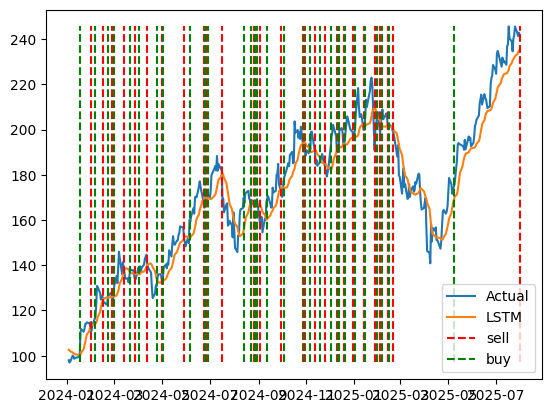

In [ ]:
plt.plot(period_of_interest[1:], df_fitresult['Actual'].loc[period_of_interest[1:]], label='Actual')
plt.plot(period_of_interest[1:], df_fitresult['LSTM'].loc[period_of_interest[1:]], label='LSTM')

max_price = np.max(df_fitresult['Actual'].loc[period_of_interest[1:]])
min_price = np.min(df_fitresult['Actual'].loc[period_of_interest[1:]])

plt.vlines(sell_time['LSTM'], min_price, max_price, color='r', linestyles='--', label="sell")
plt.vlines(buy_time['LSTM'], min_price, max_price, color='g', linestyles='--', label="buy")

plt.legend(loc='lower right')

print(f"profit: {profit['LSTM']}")

profit: 42.90819549560547


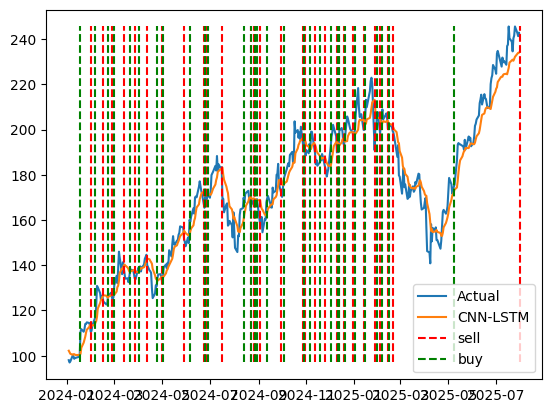

In [ ]:
plt.plot(period_of_interest[1:], df_fitresult['Actual'].loc[period_of_interest[1:]], label='Actual')
plt.plot(period_of_interest[1:], df_fitresult['CNN-LSTM'].loc[period_of_interest[1:]], label='CNN-LSTM')

max_price = np.max(df_fitresult['Actual'].loc[period_of_interest[1:]])
min_price = np.min(df_fitresult['Actual'].loc[period_of_interest[1:]])

plt.vlines(sell_time['LSTM'], min_price, max_price, color='r', linestyles='--', label="sell")
plt.vlines(buy_time['LSTM'], min_price, max_price, color='g', linestyles='--', label="buy")

plt.legend(loc='lower right')

print(f"profit: {profit['CNN-LSTM']}")

profit: 84.23878479003906


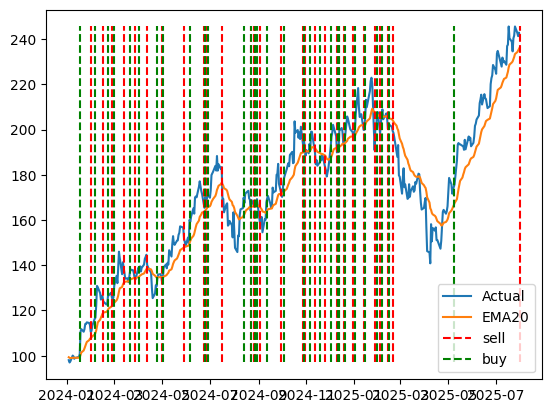

In [ ]:
plt.plot(period_of_interest[1:], df_fitresult['Actual'].loc[period_of_interest[1:]], label='Actual')
plt.plot(period_of_interest[1:], df_fitresult['EMA20'].loc[period_of_interest[1:]], label='EMA20')

max_price = np.max(df_fitresult['Actual'].loc[period_of_interest[1:]])
min_price = np.min(df_fitresult['Actual'].loc[period_of_interest[1:]])

plt.vlines(sell_time['LSTM'], min_price, max_price, color='r', linestyles='--', label="sell")
plt.vlines(buy_time['LSTM'], min_price, max_price, color='g', linestyles='--', label="buy")

plt.legend(loc='lower right')

print(f"profit: {profit['EMA20']}")

## **Conclusion**

From the result, both LSTM line and CNN-LSTM lines can be used for trading in Bullish market but the overall performance are worsen than EMA20 or simply buy-and-hold. The main reson for their poor performance is the high frequent buy-and-sell action in the raising trend so that they miss part of the raised price. In addition, if the trading fee are taken in to account, the performance would be further wrosen. However, they can still provide a selling signal when the market changes from bullish to bearish but there would be too much noise signal which may cause improper decision.